In [11]:
""" Check missing stations from all datasets, 
and create distrubtions and location plots."""

import pandas as pd
import xarray as xr
import os,sys
import numpy as np
import glob
import matplotlib.pyplot as plt
import glob
from multiprocessing import Pool
from functools import partial
import shapely
from shapely.geometry import Point, Polygon    
import geopandas as gpd

out_dir = 'Plots/Stat_Conf_Analysis'
os.system('mkdir Plots')
os.system('mkdir ' + out_dir)

""" Create a list of up-to-date missing station files, taken from the harvested files """
harvested_dir = '/raid60/scratch/federico/HARVESTED_JAN2021/'
dirs = ['bufr', 'ncar' , 'era5_1' , 'era5_2' , 'era5_3188' , 'era5_1759' , 'era5_1761' , 'igra2' ]
f = 'unidentified_station_files.txt'
if not os.path.isfile(f):
    a = open(f , 'w')
    for d in dirs:
        print('Doing ', d)
        for f in os.listdir(harvested_dir + '/' + d):
            if '.nc' not in f:
                continue
            if f[0] == '-':
                if d == 'era5_1':
                    name = f.split('_harvested_')[1].replace('.??????','').replace('.txt.gz.nc','')
                else:
                    name = f.split('_harvested_')[1].replace('.gz.nc','').replace('.nc','')
                a.write(d + '\t' + name + '\n')
        print('done ' , d )
    a.close()

df = pd.read_csv('unidentified_station_files.txt')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator


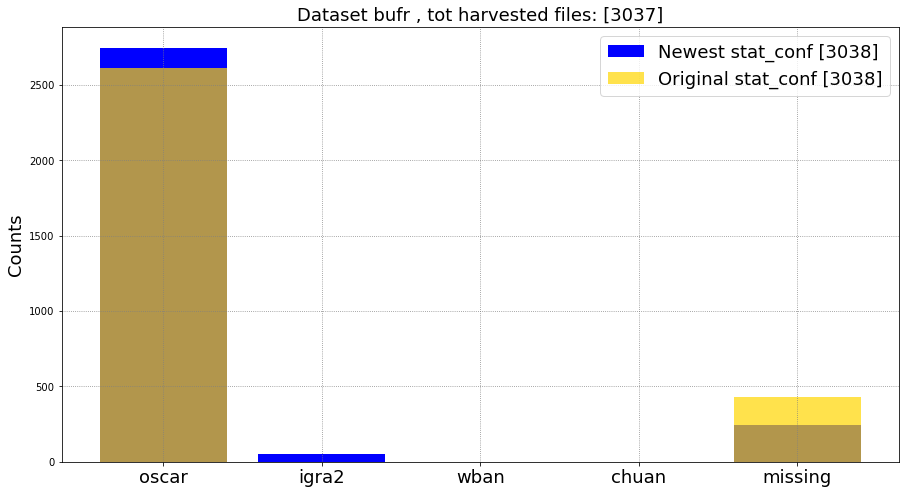

<Figure size 432x288 with 0 Axes>

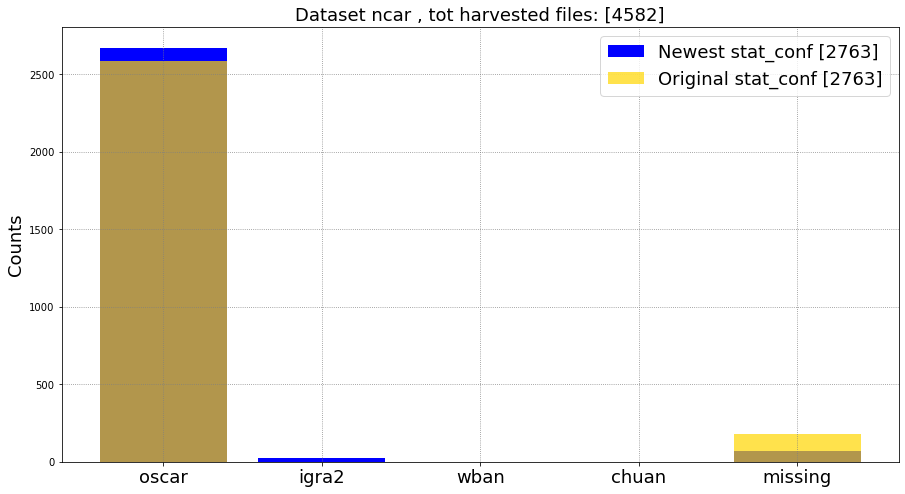

<Figure size 432x288 with 0 Axes>

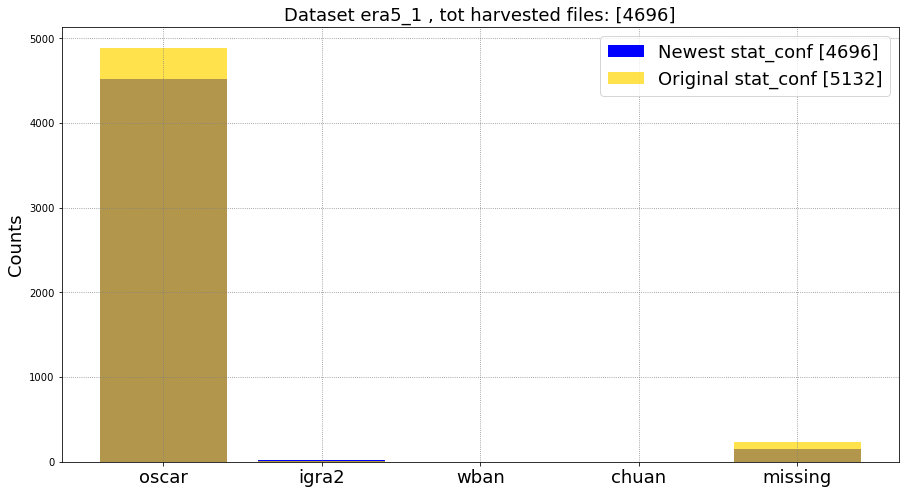

<Figure size 432x288 with 0 Axes>

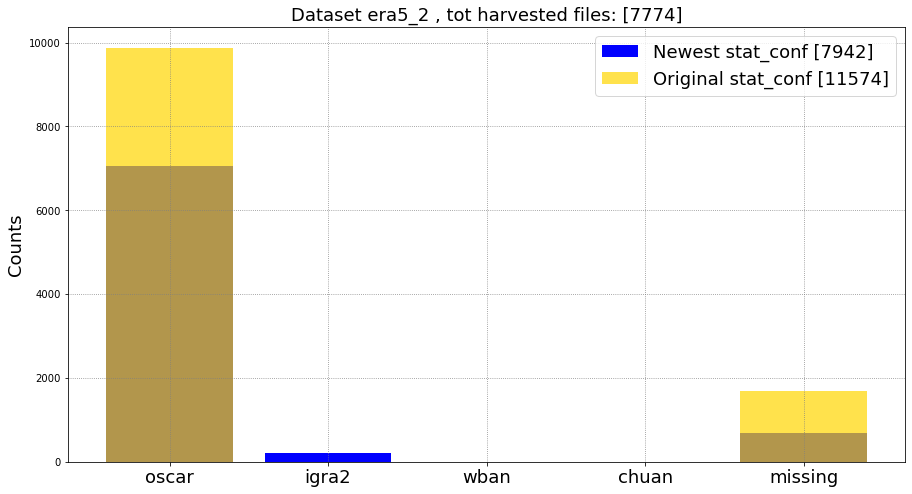

<Figure size 432x288 with 0 Axes>

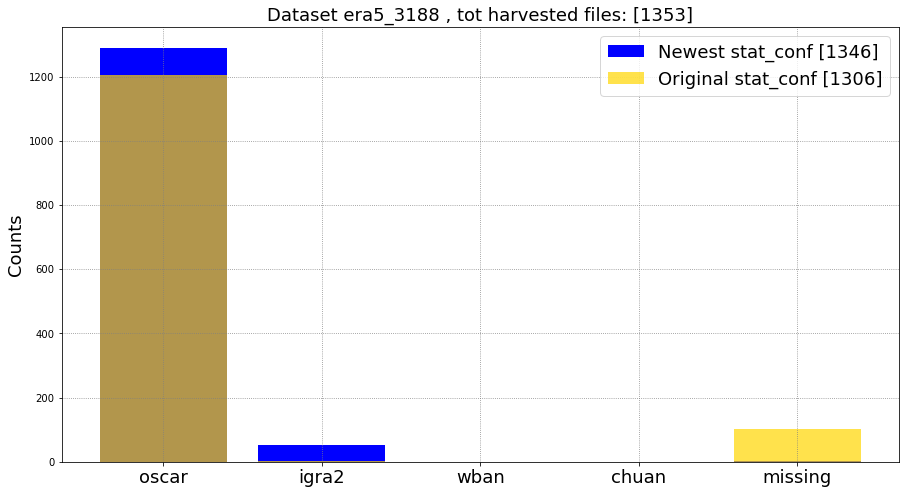

<Figure size 432x288 with 0 Axes>

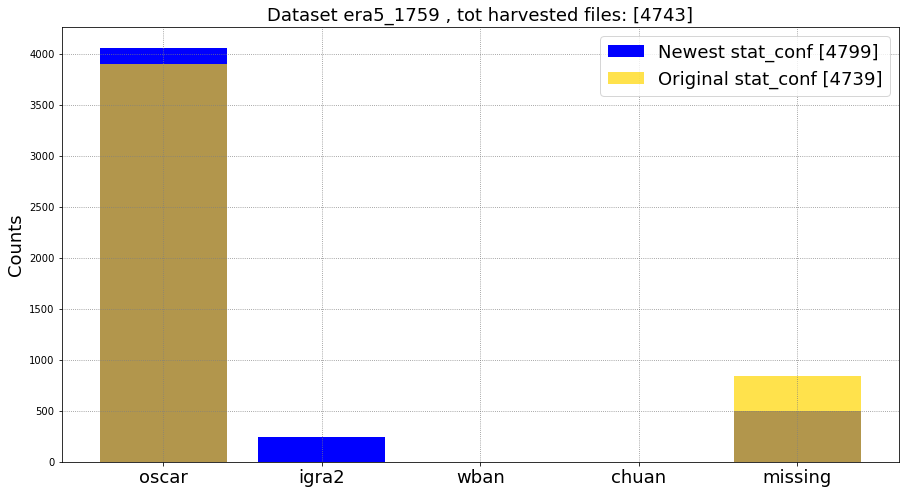

<Figure size 432x288 with 0 Axes>

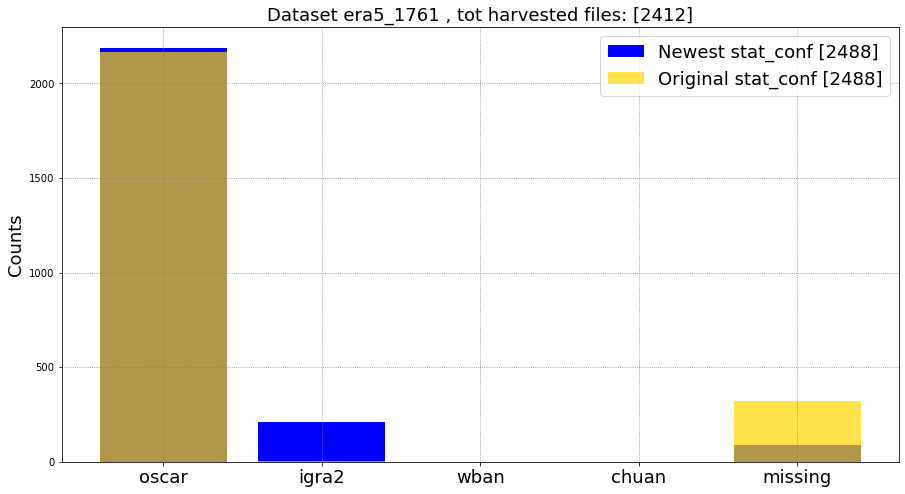

<Figure size 432x288 with 0 Axes>

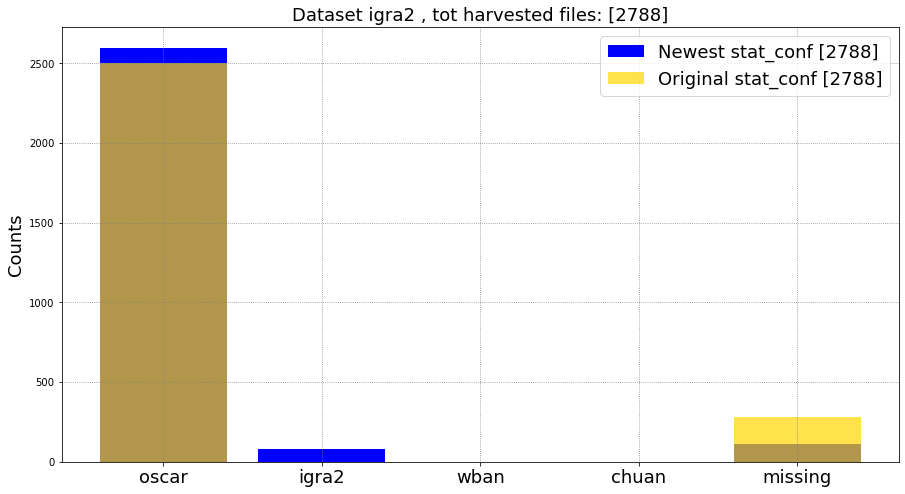

Finished analyzing station_configurations files - bar plots 


<Figure size 432x288 with 0 Axes>

In [12]:
""" Comparison of the very first station_configuration files,
and the latest files created in Jan 2021 with the updated version
of build_inventory.

Analysing the information contained in old versions of the station_configuration files
that are downloaded from GitHub history """

# base path of th eGitHub history (NB era5_2 was added later on wrt all the others)
d = 'raw.githubusercontent.com/MBlaschek/CEUAS/'
os.system('mkdir first_stat_conf' )
F = [d+'b44108ec9aa38c470b3b5355e82d6eff35a0dee3/CEUAS/public/harvest/data/station_configurations/station_configuration_ncar.dat',
        d+'b44108ec9aa38c470b3b5355e82d6eff35a0dee3/CEUAS/public/harvest/data/station_configurations/station_configuration_era5_3188.dat',
        d+'b44108ec9aa38c470b3b5355e82d6eff35a0dee3/CEUAS/public/harvest/data/station_configurations/station_configuration_era5_1761.dat',
        d+'b44108ec9aa38c470b3b5355e82d6eff35a0dee3/CEUAS/public/harvest/data/station_configurations/station_configuration_era5_1.dat',
        d+'b44108ec9aa38c470b3b5355e82d6eff35a0dee3/CEUAS/public/harvest/data/station_configurations/station_configuration_bufr.dat',
        d+'b44108ec9aa38c470b3b5355e82d6eff35a0dee3/CEUAS/public/harvest/data/station_configurations/station_configuration_era5_1759.dat',
        d+'caaaef77338ba3eb726b74d45cdc9adf1dd9ab29/CEUAS/public/harvest/data/station_configurations/station_configuration_era5_2.dat' ,
        d + 'b44108ec9aa38c470b3b5355e82d6eff35a0dee3/CEUAS/public/harvest/data/station_configurations/station_configuration_igra2.dat' ]

for f in F:
   os.system('wget -P old_stat_conf ' + f )
    

""" Copy most up-to-date stat_conf files contained in the harvester/data/station_configuration directory"""
os.system ('cp -r /raid8/srvx1/federico/GitHub/CEUAS_master_JANUARY2021/CEUAS/CEUAS/public/harvest/data/station_configurations new_stat_conf')        


def count(df):
    """ For each station_conf in a dataframe format, 
    counting the files asisgned to each inventory (OSCAR, IGRA2, WBAN, CHUAN, missing)
    Return 5 numbers"""
    oscar, igra2, wban, chuan, missing = 0,0,0,0,0
    pids = list (df['primary_id'].astype(str) )
    
    for p in pids:
        if p[0] == '-' or  '[' in p :  # possibile missing stat identifier 
            missing += 1 
            #print('missing ' , p )
        elif '-2000' in p:
            oscar += 1
        elif '-20300':
            igra2 += 1
        elif '-20400':
            wban += 1
        elif '-20500':
            chuan += 1      
        else: 
            print('oscar' , p)
            oscar += 1
            
    return oscar, igra2, wban, chuan, missing
    

dirs = ['bufr', 'ncar' , 'era5_1' , 'era5_2' , 'era5_3188' , 'era5_1759' , 'era5_1761' , 'igra2']
# Make a bar plot for each dataset
for d in dirs:
    name = 'station_configuration_' + d + '.dat'
    new = pd.read_csv( 'new_stat_conf' + '/' + name , sep = '\t'  )
    old   = pd.read_csv( 'old_stat_conf' + '/' + name , sep = '\t'  )
    
    oscar, igra2, wban, chuan, missing = count(new)
    y_n = [oscar, igra2, wban, chuan, missing]
    
    oscar, igra2, wban, chuan, missing = count(old)
    y_o = [oscar, igra2, wban, chuan, missing]
    
    x = [1,2,3,4,5]
    

    fs = 18
    fig, ax = plt.subplots(figsize=(15,8))
    labels = ['', 'oscar', 'igra2', 'wban', 'chuan', 'missing']
    ax.set_xticklabels(labels, fontsize = fs)
    
    harvested_files = str( len ( [ f for f in os.listdir(harvested_dir + '/' + d) if '_harvested_' in f ] ) )
    
    plt.bar(x, y_n , color= 'blue', label = 'Newest stat_conf [' + str(sum(y_n)) + ']')
    plt.bar(x, y_o , color= 'gold' , label = 'Original stat_conf [' + str(sum(y_o)) + ']', alpha = 0.7)
    plt.legend( fontsize = fs)
    plt.title ('Dataset ' + d + ' , tot harvested files: [' + harvested_files + ']' , fontsize = fs )
    plt.ylabel('Counts' , fontsize = fs)
    os.system ('mkdir Plots_stat_conf' )
    plt.grid(ls = ':' , color = 'gray')
    plt.show()
    plt.savefig(out_dir + '/stat_conf_bars_' + d + '.png' , dpi = 200 )
    
 

print('Finished analyzing station_configurations files - bar plots ')

In [45]:
files = glob.glob('/raid60/scratch/leo/scratch/era5/odbs/1/era5.conv._*')
print(len(files))

4704


In [50]:
# Reading th elist of misisng files from the merged directory
missing_files = {}
for d in dirs:
    missing_files[d] = []
    for f in os.listdir(harvested_dir + '/' + d):
        path = harvested_dir + '/' + d + '/' + f 
        if '.nc' not in f:
            continue
        if f[0] == '-':   
            missing_files[d].append(path)
            
 
print('Done reading missing files *** ')
def analyze_missing_station_records(path):
    try:
        #print('Doing' , path)
        sc = xr.open_dataset(path , engine = 'h5netcdf' , group = 'station_configuration' , decode_times = False )
        lat, lon = sc['latitude'].values[0],  sc['longitude'].values[0]
        if lon > 180:
            lon = lon - 360
        size = os.path.getsize(path) / 10**6 
    
        ts = xr.open_dataset(path , engine = 'h5netcdf' , decode_times = False )['recordtimestamp'][:].values
        min_date, max_date = min(ts), max (ts)
        #print(path)        
        return [lat, lon, size, min_date, max_date, len(ts)]
    
    except:
        pass
        #print('Failing ' , path )
        #return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ]
    
    
    
    
func=partial(analyze_missing_station_records)
p=Pool(40)    
missing_data = {}

#missing_data=p.map(func,files)
#missing_data=p.map(func,f)

#for fi,num in zip(files, range(len(files)) ) :
 #   a = analyze_missing_station_records(fi)
    
print(1)

for k in missing_files.keys():
    missing_data[k] = {}
    files = missing_files[k]
    #missing_data=list(p.map(func,f))
    data=p.map(func,files)
    for i,v in zip([0,1,2,3,4,5] , ['lat',  'lon', 'size', 'min_date', 'max_date', 'records' ] ):
        values = [v for v in data if v ]
        missing_data[k][v] = [ p[i] for p in values  ]
    print('Exracted data')
    
    

Done reading missing files *** 
1
Exracted data
Exracted data
Exracted data
Exracted data
Exracted data
Exracted data
Exracted data
Exracted data


In [64]:
def plot_station_prop(): 
    """ Getting the WMO regions json file """
    WMO_json = 'WMO_regions.json'
    
    if not os.path.isfile(WMO_json):
        os.system( 'wget https://cpdb.wmo.int/js/json/WMO_regions.json --no-check-certificate ')

    WMO =  gpd.read_file('WMO_regions.json')
    return WMO, out_dir
    
    
def plot_stations(data, what = 'records', era5_1759 = False):

    #clb=f.colorbar(c,ax=ax,orientation='horizontal')                                                                                                                                                                                                                                     
    #clb.ax.set_title('{:6.4f}'.format(np.mean(ds[k]).values/43200)+' '+units)                                                                                                                                                                                                            

    WMO, out_dir = plot_station_prop()
    for d in data.keys():
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        world = world.plot()
        WMO.plot( ax=world,  facecolor="none", edgecolor="lightgray", lw = 0.8)
        if not era5_1759:
            lat, lon, records= data[d]['lat'] , data[d]['lon'], data[d]['records']
            if what == 'records':
                plotto = plt.scatter( lon, lat , c= records,  s = 0.7, cmap='rainbow' )
                cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar
                cbar.set_label('Number of Records ')
                num = len ([r for r in records if r > 100 ])
                plt.clim(0, 15000)
                plt.title ('Dataset: ' + d + ' , ' + str(num) + ' stations with >100 records', fontsize = 12)

            elif what == 'date':
                date = np.array(data[d]['max_date']) / (3600*24*365) + 1900 
                plotto = plt.scatter( lon, lat , c= date,  s = 0.7, cmap='rainbow' )
                cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar
                cbar.set_label('Latest Observation Date')
                plt.clim(1950, 2020)

                plt.title ('Dataset: ' + d , fontsize = 12)
            
        else:
            lat, lon = data[d]['lat'] , data[d]['lon']
            lat_miss, lon_miss = data[d]['lat_miss'] , data[d]['lon_miss']
            plotto = plt.scatter( lon, lat , label = 'Latitude Mismatch',  s = 0.7 , marker ='*' , color = 'magenta')
            plotto = plt.scatter( lon_miss, lat_miss , label = 'Unidentified',  s = 0.7 , color = 'lime')
            plt.title('Dataset era5_1759 new', fontsize = 12)
            plt.legend(fontsize = 8)

            
        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])
        plt.savefig(out_dir + '/MissingId_location_' + d + '_' + what + '.png', dpi= 250, bbox_inches = 'tight' )

        plt.show()
        print('Processed database ' , d )
        plt.close()

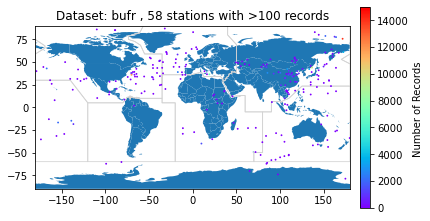

Processed database  bufr


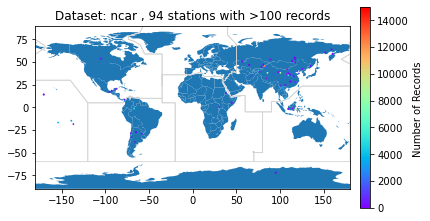

Processed database  ncar


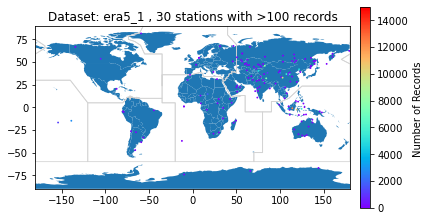

Processed database  era5_1


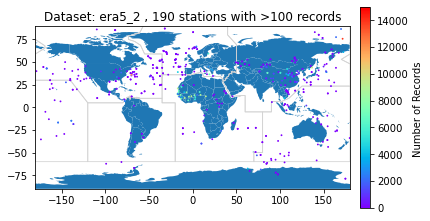

Processed database  era5_2


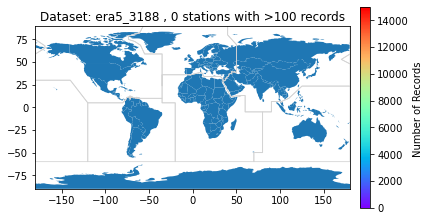

Processed database  era5_3188


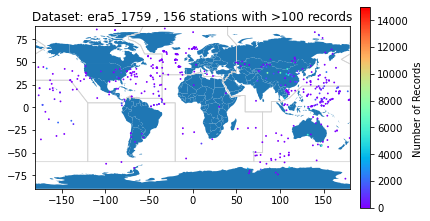

Processed database  era5_1759


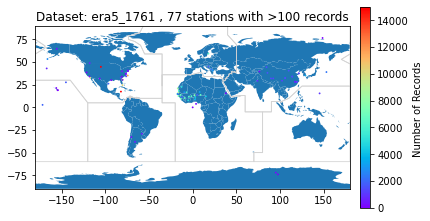

Processed database  era5_1761


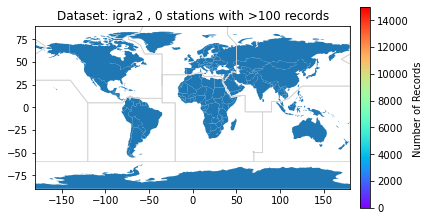

Processed database  igra2


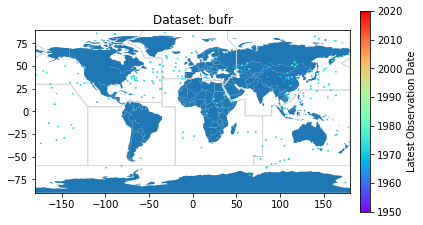

Processed database  bufr


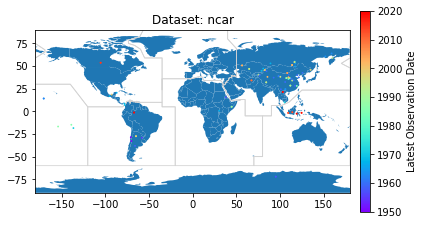

Processed database  ncar


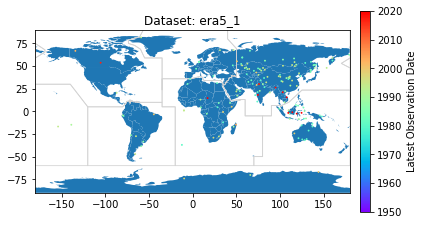

Processed database  era5_1


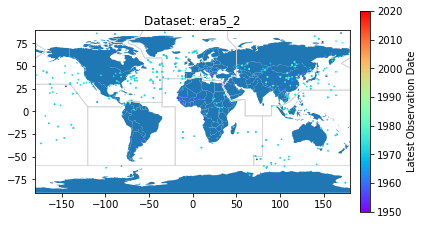

Processed database  era5_2


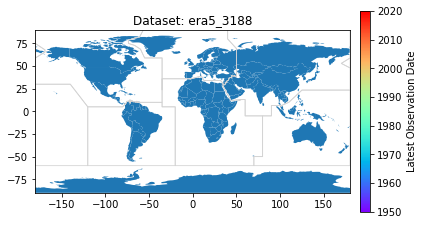

Processed database  era5_3188


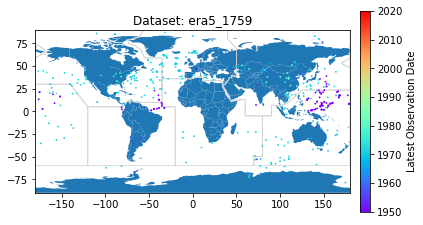

Processed database  era5_1759


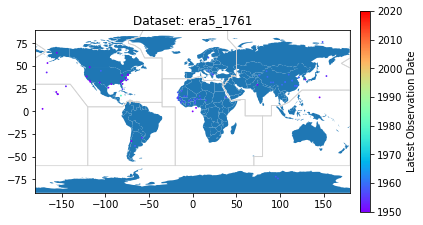

Processed database  era5_1761


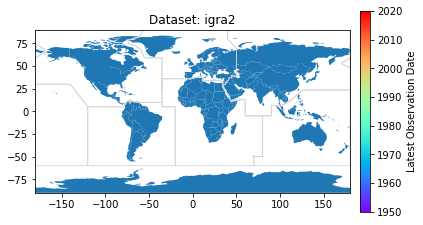

Processed database  igra2


In [65]:
dummy = plot_stations(missing_data)
dummy = plot_stations(missing_data, what = 'date')

*** Iterating 


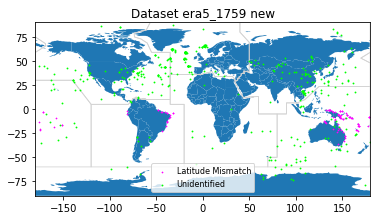

Processed database  era5_1759_new


In [62]:
# Reading the partial station:conf files containing only the newly identified files and the still missing ones
era5_1759 = pd.read_csv('1759_meta_missingId.csv', sep = '\t' )

data = {}
data['era5_1759_new'] = {}
data['era5_1759_new']['lat'] = []
data['era5_1759_new']['lon']= []

data['era5_1759_new']['lat_miss'] = []
data['era5_1759_new']['lon_miss']= []
print('*** Iterating ')
for i,row in era5_1759.iterrows():
    id = str(row['primary_id'])
    if ('20500') in id:
        data['era5_1759_new']['lat'].append(row['latitude'])
        data['era5_1759_new']['lon'].append(row['longitude'])
    else:
        data['era5_1759_new']['lat_miss'].append(row['latitude'])
        data['era5_1759_new']['lon_miss'].append(row['longitude'])
        
a = plot_stations(data, era5_1759 = True)